## 1. Introducción

En esta iteración inicial del modelo para clasificación binaria, el objetivo es predecir si el tiempo de estancia hospitalaria es prolongado (mayor a 7 días) o no. La arquitectura del modelo es similar a la utilizada previamente en la tarea de regresión, pero adaptada para esta tarea de clasificación.

El modelo utiliza un embedding preentrenado basado en el enfoque *CBOW* (`sg=0`) como entrada, seguido de dos capas LSTM unidireccionales con 128 y 64 unidades respectivamente, intercaladas con capas de Dropout para prevenir el sobreajuste. La salida del modelo es una capa densa con una activación sigmoide, adecuada para problemas de clasificación binaria.

Para entrenar el modelo, se utiliza la función de pérdida de entropía cruzada binaria (*binary crossentropy*), junto con las métricas de precisión (*accuracy*) y sensibilidad (*recall*), esta última seleccionada para abordar el desbalance presente en los datos. El entrenamiento se realiza durante 10 épocas.

## 2. Carga de Datos

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

# Estilo de gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Cargar los datos
df = pd.read_csv('otros/data/clean_subset.csv')
df.info()

2024-11-19 20:48:58.550257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732049338.567887  101312 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732049338.573296  101312 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 20:48:58.591741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hadm_id  1000 non-null   int64 
 1   text     1000 non-null   object
 2   los      1000 non-null   int64 
 3   blos     1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


In [2]:
# Dividir los datos en Train y Test
X = df['text']
y = df['blos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño de entrenamiento: {X_train.shape}")
print(f"Tamaño de prueba: {X_test.shape}")

Tamaño de entrenamiento: (800,)
Tamaño de prueba: (200,)


## 3. Preprocesamiento de Datos

In [3]:
# Tokenizar el conjunto de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convertir `X_train` y `X_test` en secuencias de tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Obtener el índice de palabras del tokenizer
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [4]:
# Seleccion de la longitud maxima para realizar el padding
sequence_lengths = [len(seq) for seq in X_train_seq]
max_sequence_length = int(np.percentile(sequence_lengths, 95))
# En este caso se define una longitud que abarque al menos el 95% de las historias clinicas para el conjunto de datos originales 
# el valor fue de max_secuence_lenhth = 1908
 
# Rellenar o truncar secuencias en ambos conjuntos
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

##  4. Entrenamiento del Modelo Word2Vec

In [5]:
# Crear listas de listas de palabras para entrenar Word2Vec
sentences = [text.split() for text in X_train]

# Entrenar el modelo Word2Vec
embedding_dim = 100
word2vec_model = Word2Vec(sentences=sentences, vector_size=embedding_dim, window=5, min_count=1)

# Generar la matriz para alamcenar los pesos
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

## 5. Construcción y Entrenamiento del Modelo

In [6]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])

/home/dsierra/miniconda3/envs/mimic/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1732049344.510748  101312 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11549 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:84:00.0, compute capability: 6.1


In [7]:
model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/10


I0000 00:00:1732049348.015682  109513 cuda_dnn.cc:529] Loaded cuDNN version 90300


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.7873 - loss: 0.6150 - recall: 0.2077 - val_accuracy: 0.8000 - val_loss: 0.5100 - val_recall: 0.1364
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.8108 - loss: 0.5060 - recall: 0.2764 - val_accuracy: 0.7800 - val_loss: 0.5289 - val_recall: 0.0000e+00
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.7900 - loss: 0.5386 - recall: 0.0099 - val_accuracy: 0.8050 - val_loss: 0.5093 - val_recall: 0.1364
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.7987 - loss: 0.5179 - recall: 0.1684 - val_accuracy: 0.8050 - val_loss: 0.4950 - val_recall: 0.1364
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.8151 - loss: 0.4919 - recall: 0.1950 - val_accuracy: 0.8050 - val_loss: 0.4960 - val_recall: 0.1364
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.7936 - loss: 0.5274 - recall: 0.1801 - val_accuracy: 0.8050 - val_loss: 0.4953 - val_recall: 0.1364
Epoch 7/10


## 6. Evaluación del Modelo

In [8]:
# Predicción sobre el conjunto de prueba
y_pred = model.predict(X_test_padded)

y_pred_class = (y_pred > 0.4).astype('int32')

1/7 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


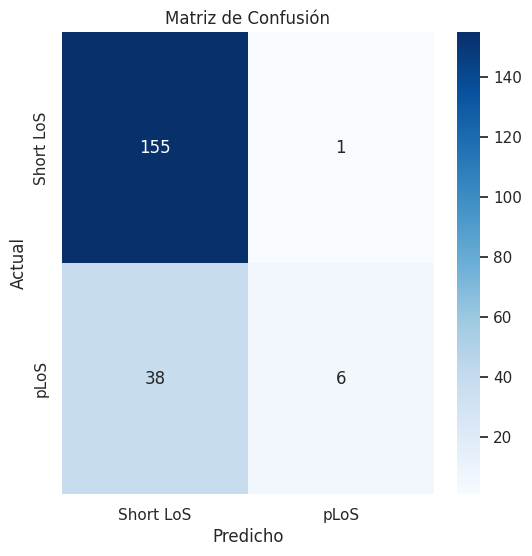

In [9]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Short LoS", "pLoS"], yticklabels=["Short LoS", "pLoS"])
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión')
plt.show()

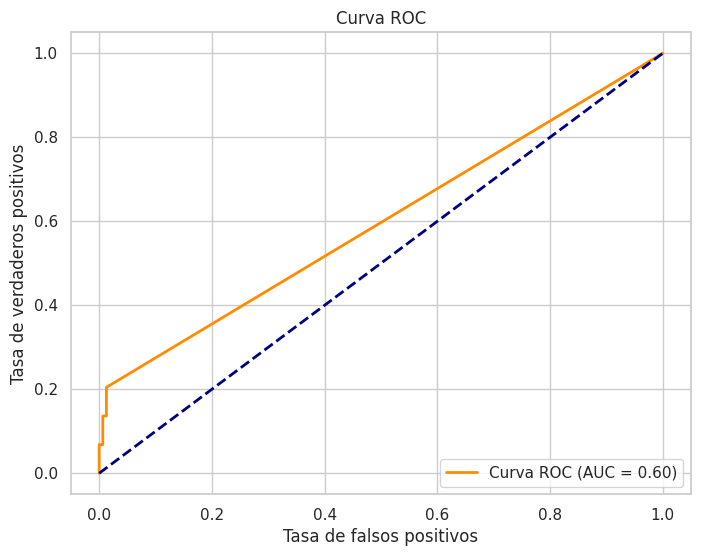

In [10]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcular el AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

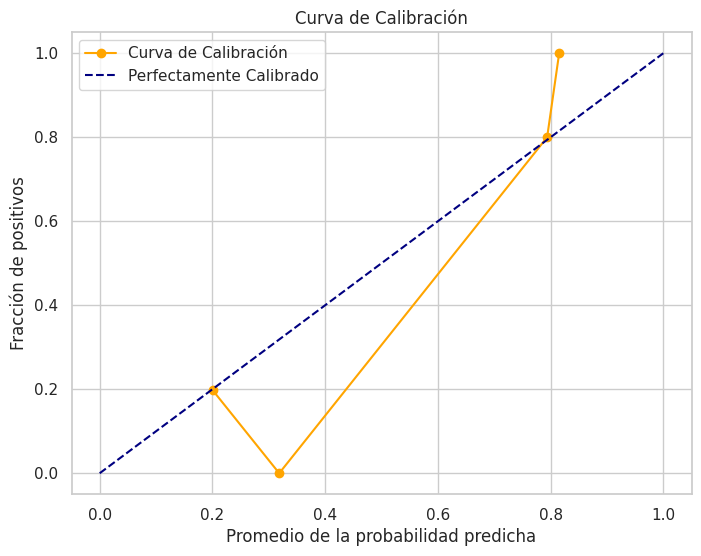

In [11]:
# Curva de calibración
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, color="orange", marker="o", label="Curva de Calibración")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Perfectamente Calibrado")
plt.xlabel('Promedio de la probabilidad predicha')
plt.ylabel('Fracción de positivos')
plt.title('Curva de Calibración')
plt.legend()
plt.show()

## 7. Resultados sobre el Conjunto de Datos original

En esta sección se presentan los resultados obtenidos al evaluar el modelo base de clasificacion entrenado sobre los datos originales, utilizando los embeddings con **sg=0** y **10 epochs**, sobre el conjunto de datos de testeo original.


### Matriz de confusión

![Matriz de confusión](otros/confusion_matrix_clas_01.png)


### Curva ROC

![Curva ROC](otros/roc_curve_clas_01.png)

### Curva de calibración

![Curva de calibración](otros/calibration_curve_clas_01.png)

In [12]:
# Cargar el modelo entrenado sobre los datos originales

model = load_model('otros/modelo_clasification_01.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1908, 100)      │    80,658,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1908, 128)      │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1908, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,825,621 (308.33 MB)

 Trainable params: 166,721 (651.25 KB)

 Non-trainable params: 80,658,900 (307.69 MB)